# Forecasting with the FBProphet model

First, I do all the imports I need

In [3]:
import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid
import logging
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


pd.plotting.register_matplotlib_converters()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

df = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
df['month'] = df.index.month
df['quarter'] = df.index.quarter

# Exploring the data

First I do some basic stats on the data.
I determine that the data isn't very seasonal (at least not that the model can catch) but it has a trend. It can definitely be decomposed into an additive model since the residual noise is just 11%
The data also is not stationary (the stationarity test fails)

 RESMEAN:2709206.45202266, OBSMEAN:23178834.207395833, PERC:11.68827745080559%
Test statistic = -2.117
P-value = 0.537
Critical values :
	1%: -4.058458386243895 - The data is not stationary with 99% confidence
	5%: -3.45827364668715 - The data is not stationary with 95% confidence
	10%: -3.1550275333981874 - The data is not stationary with 90% confidence


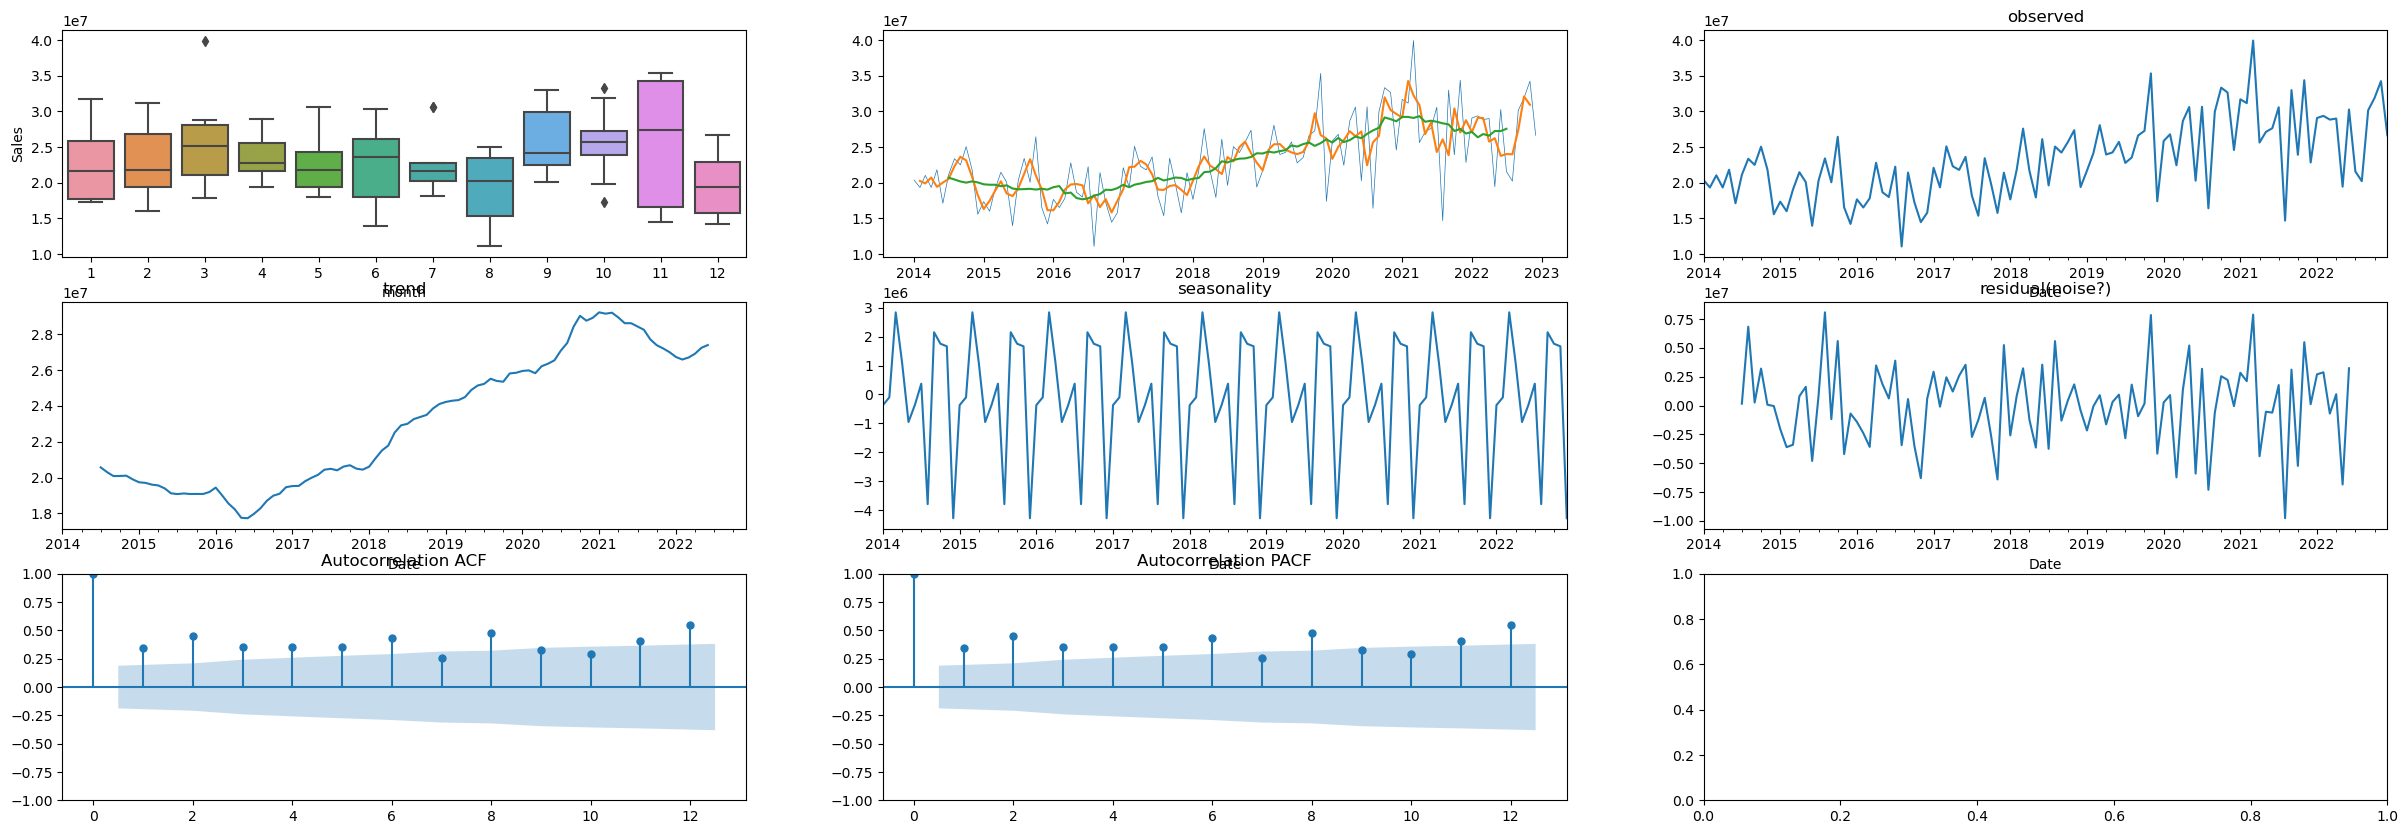

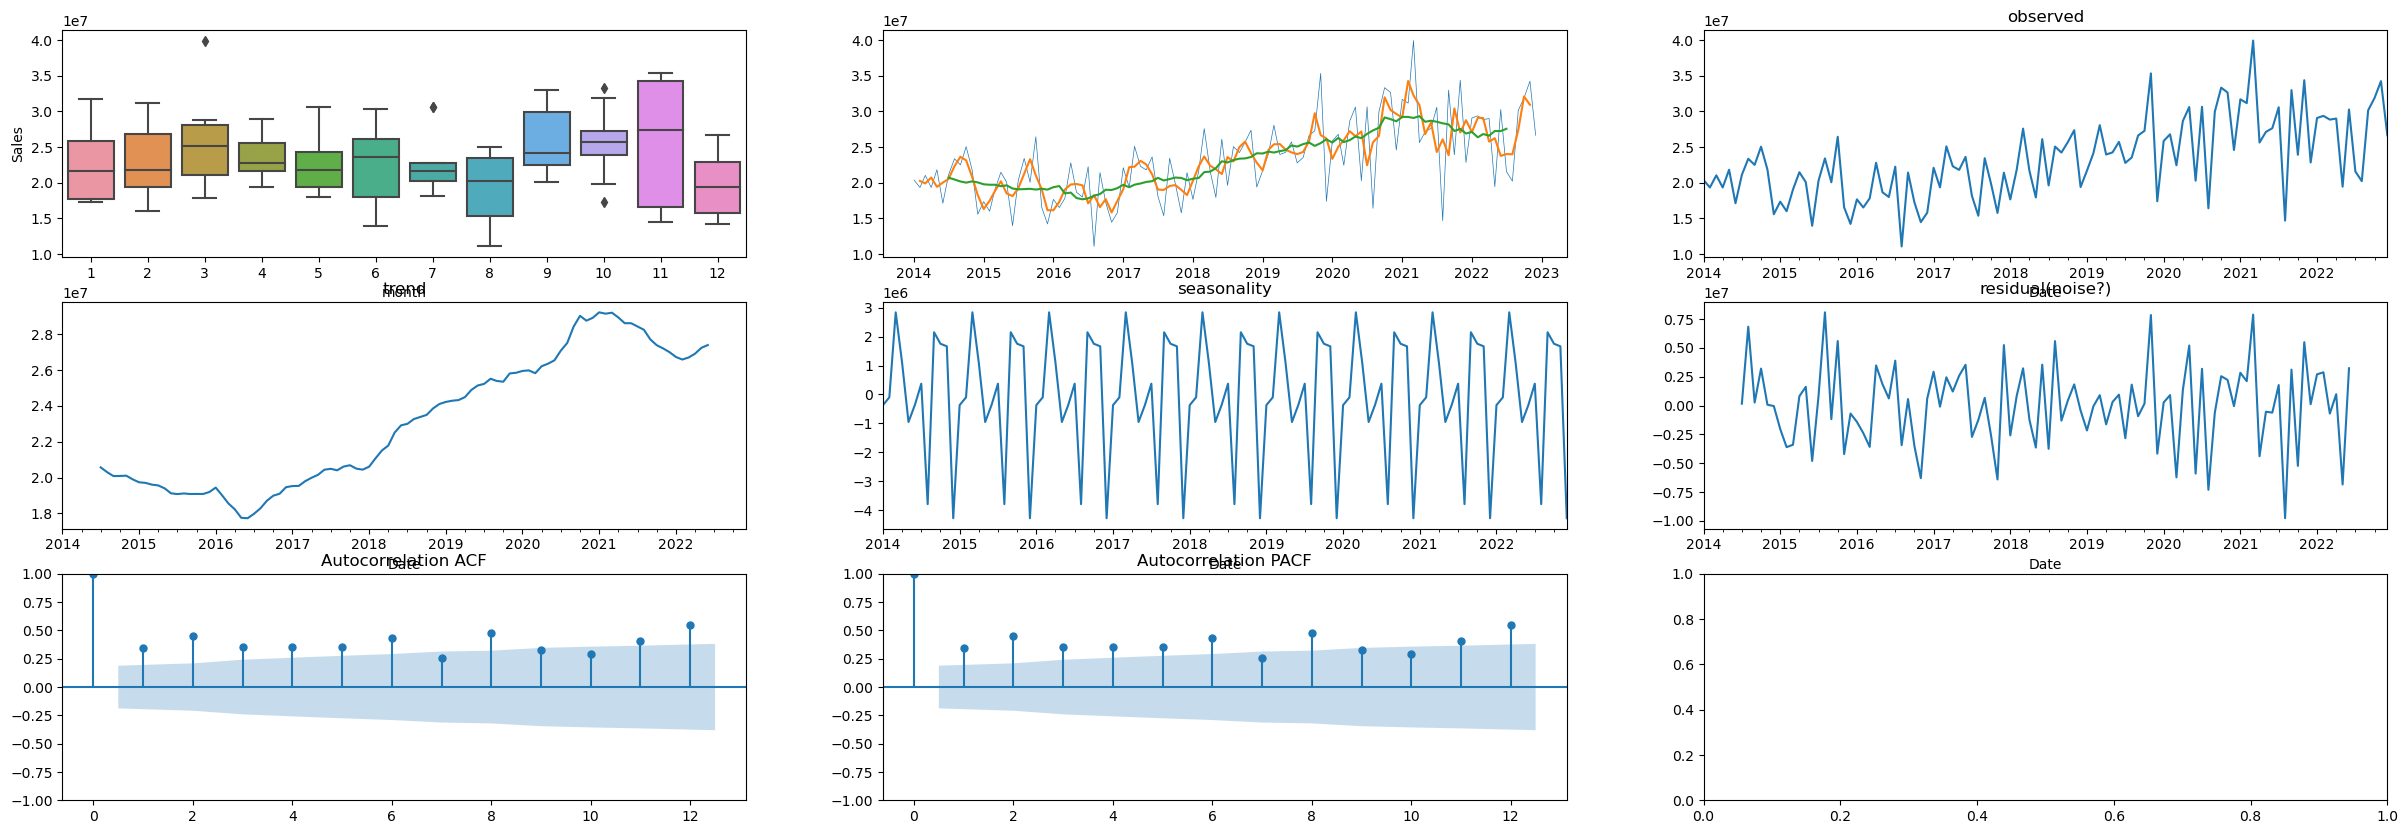

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(30, 10))

sns.boxplot(data=df, x='month', y='Sales', ax=axes[0,0])
df12mean = df['Sales'].rolling(window=12, center=True).mean()
df12std = df['Sales'].rolling(window=12, center=True).std()
df3mean = df['Sales'].rolling(window=3, center=True).mean()
df3std = df['Sales'].rolling(window=3, center=True).std()

axes[0,1].plot(df['Sales'], linewidth=0.5, label='Monthly sales')
axes[0,1].plot(df3mean, label='3-month rolling mean')
axes[0,1].plot(df12mean, label='12 months rolling mean')

result = seasonal_decompose(df['Sales'], period=12, filt=None)
result.trend.plot(ax=axes[1,0], title='trend')
result.seasonal.plot(ax=axes[1,1], title='seasonality')
result.resid.plot(ax=axes[1,2], title='residual(noise?)')
result.observed.plot(ax=axes[0,2], title='observed')

# Decompose time series into additive model
dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
dfs=dfs.dropna()
res=dfs['residuals'].values
obs=dfs['observed'].values
resmean=np.mean(np.abs(res))
obsmean=np.mean(np.abs(obs))
perc=resmean*100/obsmean
print(' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

# check for seasonality
dftest = adfuller(df['Sales'], regression='ct', autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

plot_acf(df['Sales'], lags=12, title='Autocorrelation ACF', ax=axes[2,0])
plot_acf(df['Sales'], lags=12, title='Autocorrelation PACF', ax=axes[2,1])

## Prophet forcasting

I will use the prophet model to attempt to beat naive statistical estimates. The most naive of them is simply taking the average of the last year. Another one is taking SARIMA which adds up to the "magic" 2.755568e+07 value that appears in the code on occasion.
To configure the model, we add quaterly and monthly seasonality. Each has a periodicity which parametrizes the fourier series that the ML model uses to fit the data internally.

I add an additional seasonality "is cold" to see if winter may have an effect on sales. My prior assumption is very simple: it is cold between the months of November and February.
I guess the initial parameters from the model from the statistical analysis above:
* yearly seasonality of 6 months fits autocorrelation graph
* moderate changepoint_prior_scale to allow for some change of trend since the medical market gets permanently (non-seasonaly) disrupted

First, define helper functions. There is a lot of parameters to allow for etra regressors (later)

In [146]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import math

cutoff_train_test = 12

def is_cold(el):
    return (el.month > 10 or el.month < 3)

# add "is cold" and concatenate with another time series, if provided (for external regressors)
def prepare_time_series(df, original_df = None):
    df['is_cold'] = df['ds'].apply(is_cold)
    df['is_not_cold'] = ~df['ds'].apply(is_cold)
    if original_df is not None:
        original_df_restricted = original_df.loc[df.index.min():df.index.max(),:]
        return pd.concat([df, original_df_restricted], axis=1)
        
    return df

def create_and_fit_model(
    train_df, 
    quarterly_period=0, 
    quarterly_fourier_order=5, 
    iscold_fourier_order=1,
    fourier_order_isnotcold=2,
    changepoint_prior_scale=1., 
    yearly_seasonality=5,
    iscold_period=4,
    isnotcold_period=8,
    vaccine_period = 0,
    cpi_period = 0,
    vaccine_prior_scale = 0,
    cpi_prior_scale = 0,
    vaccine_method = 'multiplicative',
    cpi_method = 'addtive'
):
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, changepoint_prior_scale=changepoint_prior_scale, yearly_seasonality=yearly_seasonality)
    if vaccine_period > 0:
        model.add_regressor('vaccine', prior_scale=vaccine_prior_scale, mode=vaccine_method)
    if cpi_period > 0:
        model.add_regressor('CPI', prior_scale=cpi_prior_scale, mode=cpi_method)

    if quarterly_period > 0:
        model.add_seasonality(name='quarterly', period=quarterly_period, fourier_order=quarterly_fourier_order)
    if iscold_period > 0:
        model.add_seasonality(name='is_cold', period=iscold_period, fourier_order=iscold_fourier_order, prior_scale = .3, condition_name='is_cold')
    if isnotcold_period > 0:
        model.add_seasonality(name='is_not_cold', period=isnotcold_period, fourier_order=fourier_order_isnotcold, prior_scale = .3, condition_name='is_not_cold')
    model.fit(train_df)
    return model

def get_percentage_err(df_gt, df_pred, naive_pred):
    df_pred = df_pred[-len(df_gt):]
    error1 = mean_squared_error(df_gt[['y']].values, df_pred[['yhat']].values)
    error2 = mean_squared_error(df_gt[['y']].values, [naive_pred
    ]*len(df_gt))
    perc_improvement = (math.sqrt(error2)-math.sqrt(error1))/max(math.sqrt(error1),math.sqrt(error2))
    return perc_improvement


def print_mserr(df_gt, df_pred, naive_pred, best = None):
    df_pred = df_pred[-len(df_gt):]
    error1 = mean_squared_error(df_gt[['y']].values, df_pred[['yhat']].values)
    error2 = mean_squared_error(df_gt[['y']].values, [naive_pred
    ]*len(df_gt))
    perc_improvement = get_percentage_err(df_gt, df_pred, naive_pred)
    if best is not None and best > math.sqrt(error1):
        print("error report:")
        print(f"Error using Prophet model: {math.sqrt(error1)}")
        print(f"Error using Naive prediction (constant value {naive_pred}) model: {math.sqrt(error2)}")
        print(f"Prophet is {perc_improvement*100:.2f}% better than naive mean prediction")
    return math.sqrt(error1)

def plot_prophet_with_parameters(df_sales, plot_components=False, **kwargs):
    print("Running with configuration:", kwargs)
    df = df_sales.reset_index()

    df=df.rename(columns={'Date':'ds', 'Sales':'y'})
    df = prepare_time_series(df)
    train_df = df[:-cutoff_train_test]
    test_df = df[-cutoff_train_test:]

    model = create_and_fit_model(train_df, **kwargs)

    future = model.make_future_dataframe(periods=12, freq = 'm')
    future = prepare_time_series(future)
    forecast = model.predict(future)

    fig, axes = plt.subplots(1, 2, figsize=(30, 10))

    fig = model.plot(forecast, ax=axes[0])
    if plot_components:
        model.plot_components(forecast)
    add_changepoints_to_plot(axes[0], model, forecast)

    train_df.set_index('ds', inplace=True)
    forecast.set_index('ds', inplace=True)

    viz_df = train_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

    viz_df[['yhat']].plot(ax=axes[1])
    df_sales[['Sales']].plot(ax=axes[1])

    print_mserr(test_df, forecast, train_df[-12:]['y'].mean(), 1e99)
    print_mserr(test_df, forecast, 2.755568e+07, 1e99)


Make a pure timeseries prediction with no external factors (except "is cold")

23:29:05 - cmdstanpy - INFO - Chain [1] start processing


Running with configuration: {}


23:29:06 - cmdstanpy - INFO - Chain [1] done processing


error report:
Error using Prophet model: 3936466.05005507
Error using Naive prediction (constant value 28542093.665000003) model: 4609301.691495028
Prophet is 14.60% better than naive mean prediction
error report:
Error using Prophet model: 3936466.05005507
Error using Naive prediction (constant value 27555680.0) model: 4502516.883681473
Prophet is 12.57% better than naive mean prediction


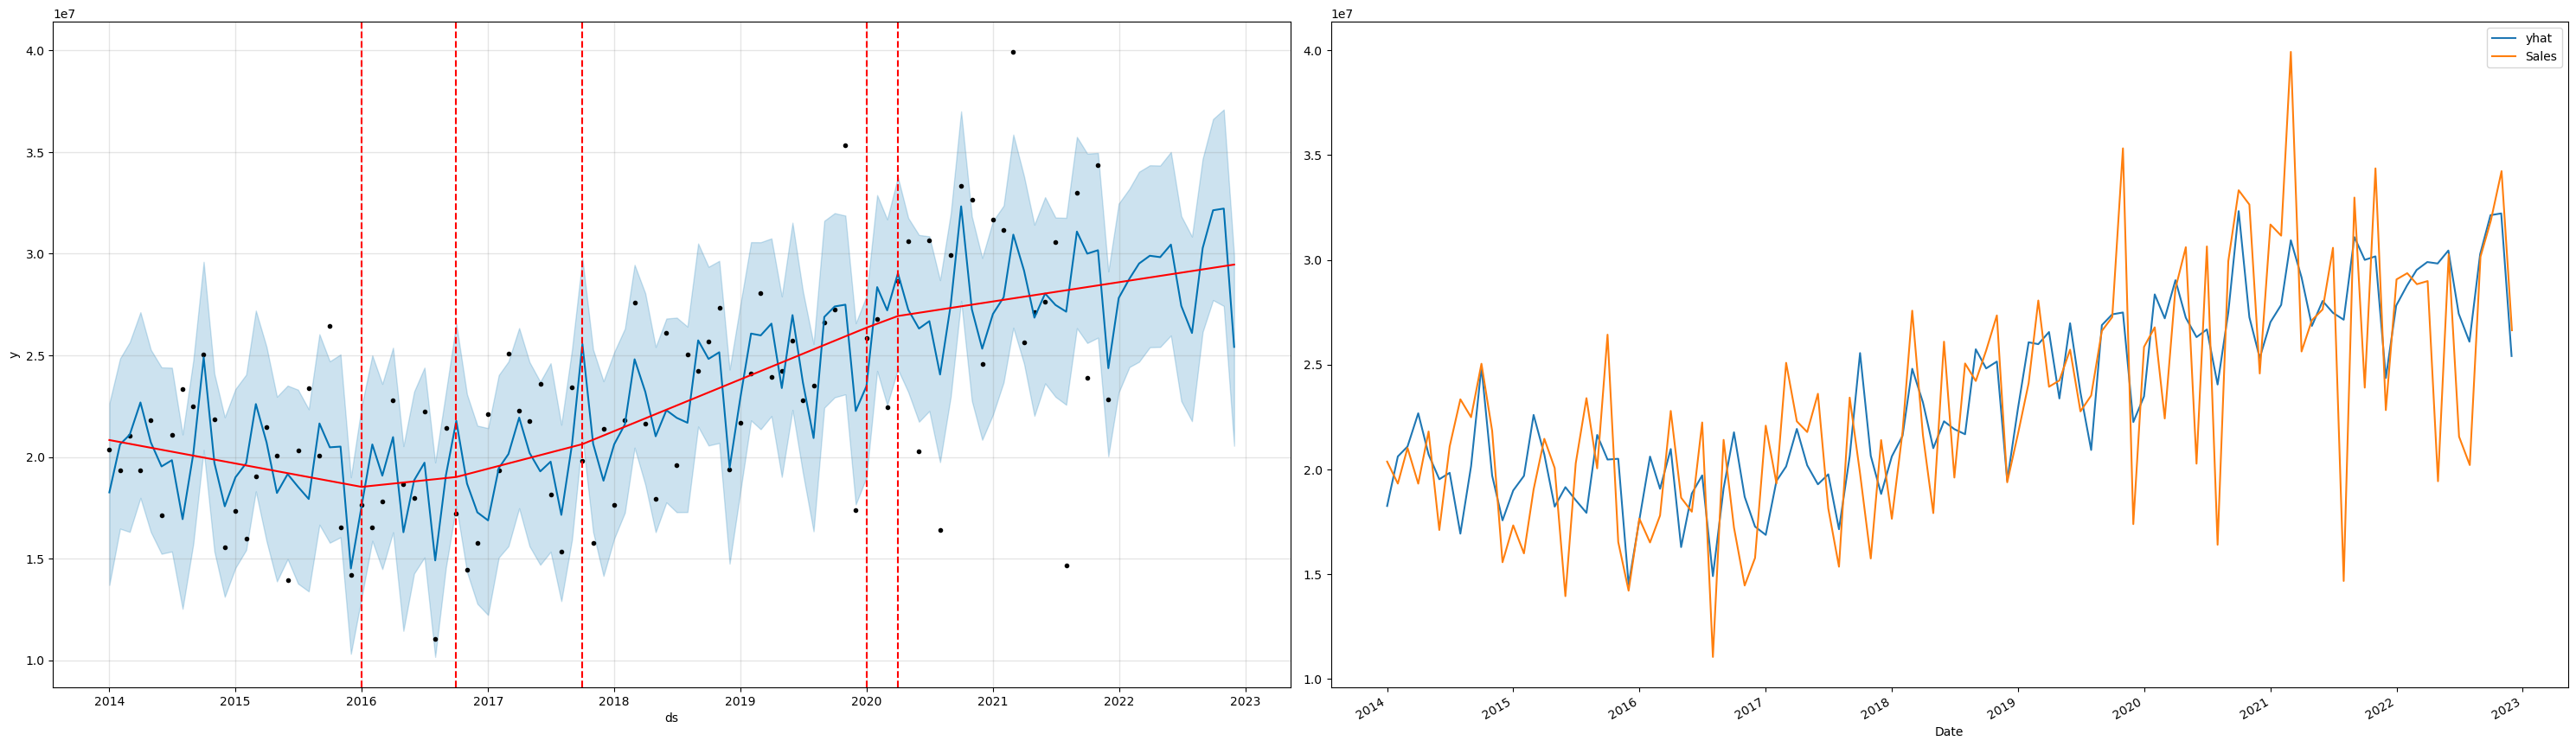

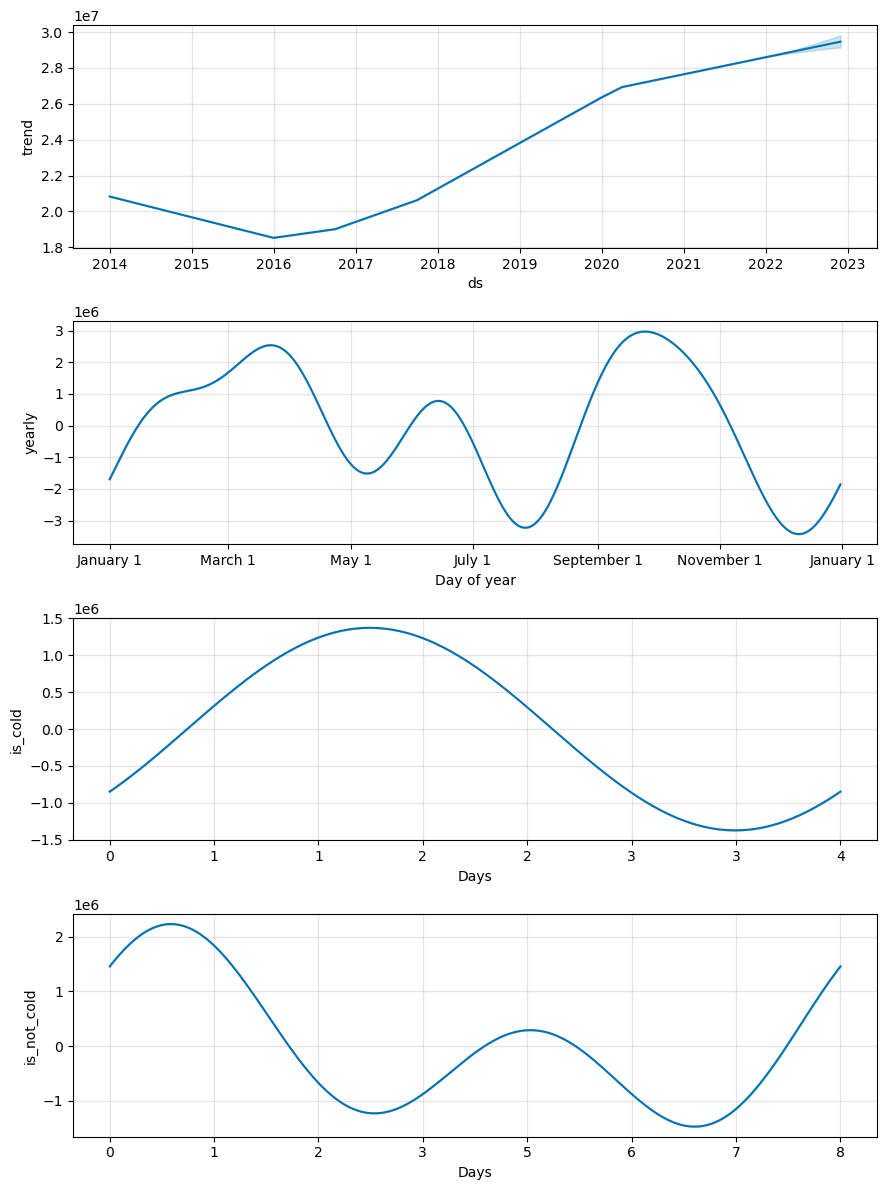

In [74]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import math

df_sales = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
plot_prophet_with_parameters(df_sales, plot_components=True)

## Mini-Conclusion

* Prophet outperforms naive statistical models: 12% improvement
* Prophet catches the trend and trend changes
* Prophet catches the seasonality around the changes


## Search for hyperparameters on grid

Let's try to optimize hyperparameters to see how far we can push prediction on this time series without resorting to external regressors

In [73]:
cutoff_train_test = 12

df_sales = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
df = df_sales.reset_index()

df=df.rename(columns={'Date':'ds', 'Sales':'y'})
df = prepare_time_series(df)
train_df = df[:-cutoff_train_test]
test_df = df[-cutoff_train_test:]

future = model.make_future_dataframe(periods=12, freq = 'm')
future = prepare_time_series(future)



In [ ]:
params_grid = {
    'changepoint_prior_scale': [2,2.5,3, 4, 5,6,7], 
    'fourier_order_isnotcold': [2,3,5,1], 
    'iscold_fourier_order': [2,3], 
    'iscold_period': [2,3,5,0], 
    'isnotcold_period': [4,2,5,0], 
    'quarterly_fourier_order': [1,2,3,5], 
    'quarterly_period': [1,3,0], 
    'yearly_seasonality': [6,4,5,7,8,9]} 

grid = ParameterGrid(params_grid)
best_grid=None
best_score = 1e99
nb_grid = len(grid)
iteration = 0
skipped_iter=0
print(f"Running on {nb_grid} parameter combinations")
for p in grid:
    # No need to cycle through fourier orders more than once
    # when the quarterly period is disabled
    if p['quarterly_period'] == 0 and p['quarterly_fourier_order'] > 1:
        iteration+=1
        skipped_iter+=1
        continue
    if p['iscold_period'] == 0 and p['iscold_fourier_order'] > 1:
        iteration+=1
        skipped_iter+=1
        continue
    if p['isnotcold_period'] == 0 and p['fourier_order_isnotcold'] > 1:
        iteration+=1
        skipped_iter+=1
        continue
    model = create_and_fit_model(train_df,**p)
    forecast = model.predict(future)

    score = print_mserr(test_df, forecast, train_df[-12:]['y'].mean(), best_score)

    if (score < best_score):
        print(f"[{iteration}/{nb_grid} ({skipped_iter} skipped)]New best grid! {p} scoring {score}")
        best_score = score
        best_grid = p
    iteration+=1


Found 2 interesting configurations:
* `{'changepoint_prior_scale': 7, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 3, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 2, 'quarterly_period': 1, 'yearly_seasonality': 5}` scoring 3290918.8791549434 (28.60% better than naive mean prediction)
However, this creates very short-term trends, lowering confidence in longer term predictions (>1 month) since the model keeps the same trend after the end of the training data.
* `{'changepoint_prior_scale': 2.5, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 1, 'quarterly_period': 1, 'yearly_seasonality': 5}` scoring 3408321.2055835156 (26.06% better than naive mean prediction)
This configuration is arguably better because it detects longer, more sustainable trends around which seasonality appears even if the score is a little bit less on this particular test set. For longer-term prediction, this configuration is preferred.


00:11:38 - cmdstanpy - INFO - Chain [1] start processing


Running with configuration: {'changepoint_prior_scale': 7, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 3, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 2, 'quarterly_period': 1, 'yearly_seasonality': 5}


00:11:38 - cmdstanpy - INFO - Chain [1] done processing
00:11:38 - cmdstanpy - INFO - Chain [1] start processing


error report:
Error using Prophet model: 3300468.1178417844
Error using Naive prediction (constant value 28542093.665000003) model: 4609301.691495028
Prophet is 28.40% better than naive mean prediction
error report:
Error using Prophet model: 3300468.1178417844
Error using Naive prediction (constant value 27555680.0) model: 4502516.883681473
Prophet is 26.70% better than naive mean prediction
Running with configuration: {'changepoint_prior_scale': 2.5, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 1, 'quarterly_period': 1, 'yearly_seasonality': 5}


00:11:39 - cmdstanpy - INFO - Chain [1] done processing
00:11:40 - cmdstanpy - INFO - Chain [1] start processing


error report:
Error using Prophet model: 3417043.511239378
Error using Naive prediction (constant value 28542093.665000003) model: 4609301.691495028
Prophet is 25.87% better than naive mean prediction
error report:
Error using Prophet model: 3417043.511239378
Error using Naive prediction (constant value 27555680.0) model: 4502516.883681473
Prophet is 24.11% better than naive mean prediction
Running with configuration: {}


00:11:40 - cmdstanpy - INFO - Chain [1] done processing


error report:
Error using Prophet model: 3936466.05005507
Error using Naive prediction (constant value 28542093.665000003) model: 4609301.691495028
Prophet is 14.60% better than naive mean prediction
error report:
Error using Prophet model: 3936466.05005507
Error using Naive prediction (constant value 27555680.0) model: 4502516.883681473
Prophet is 12.57% better than naive mean prediction


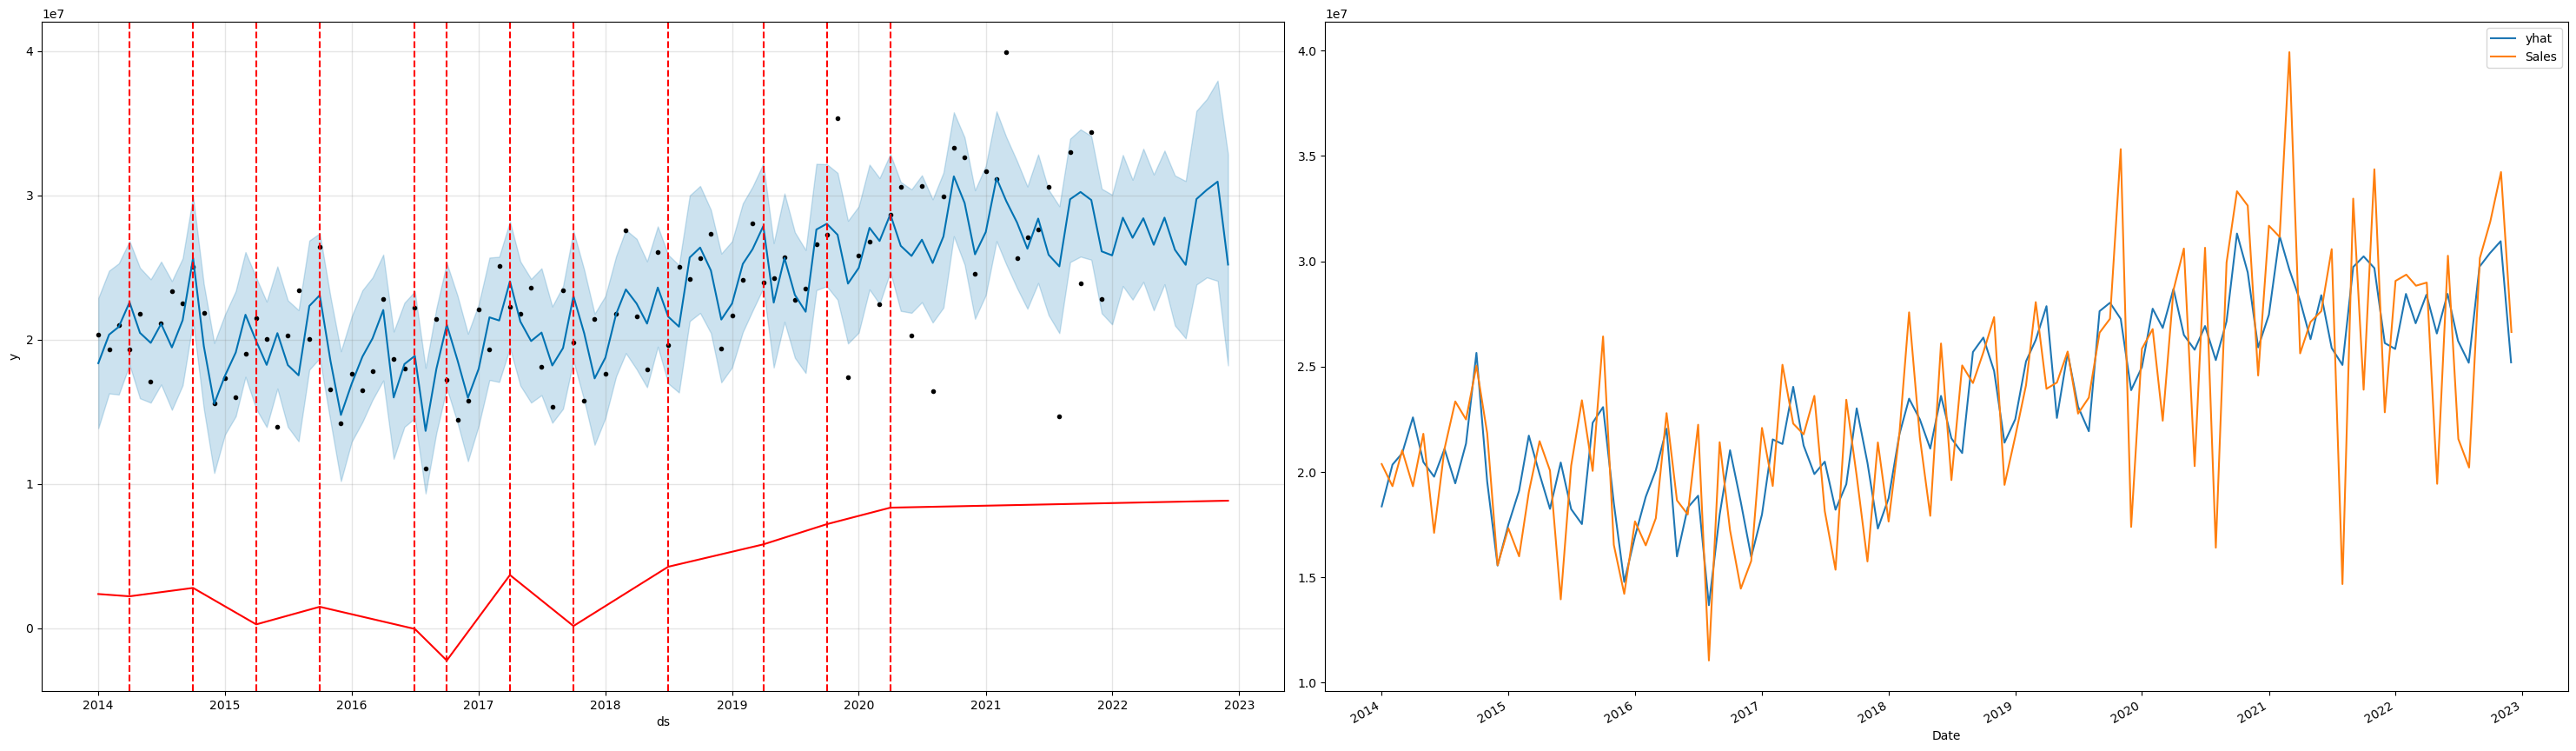

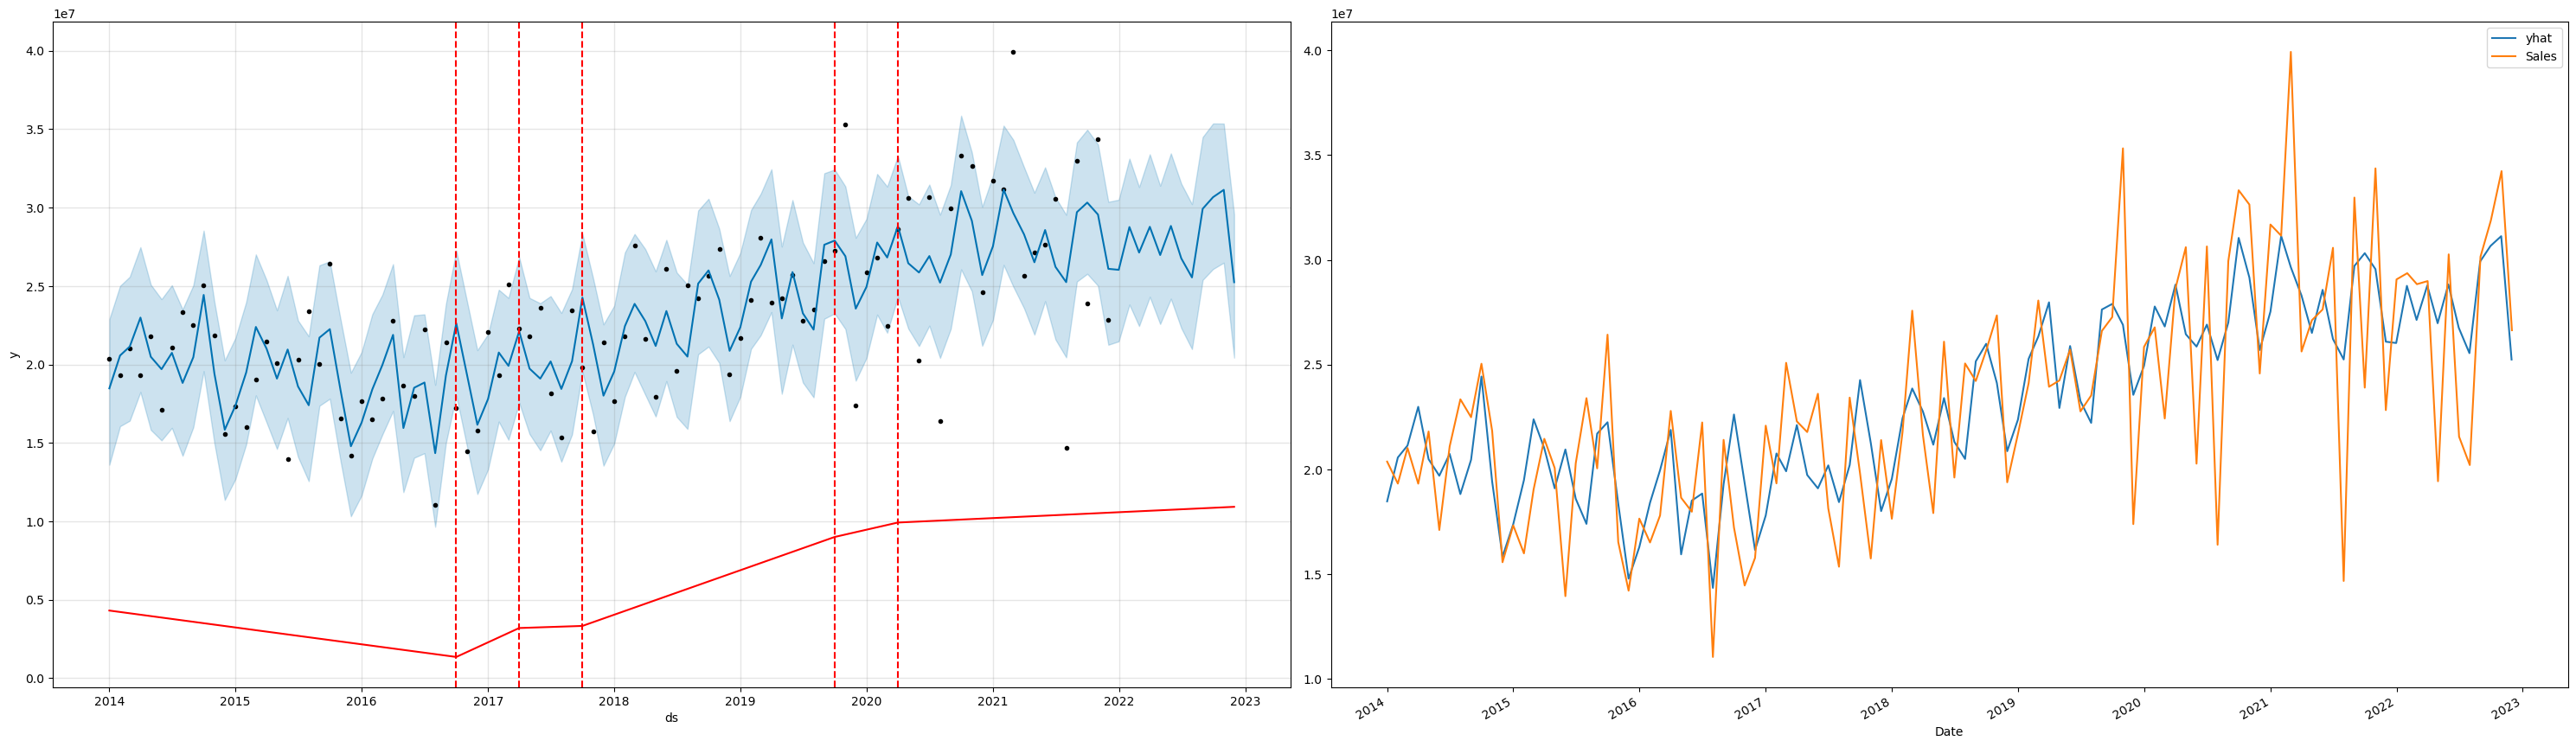

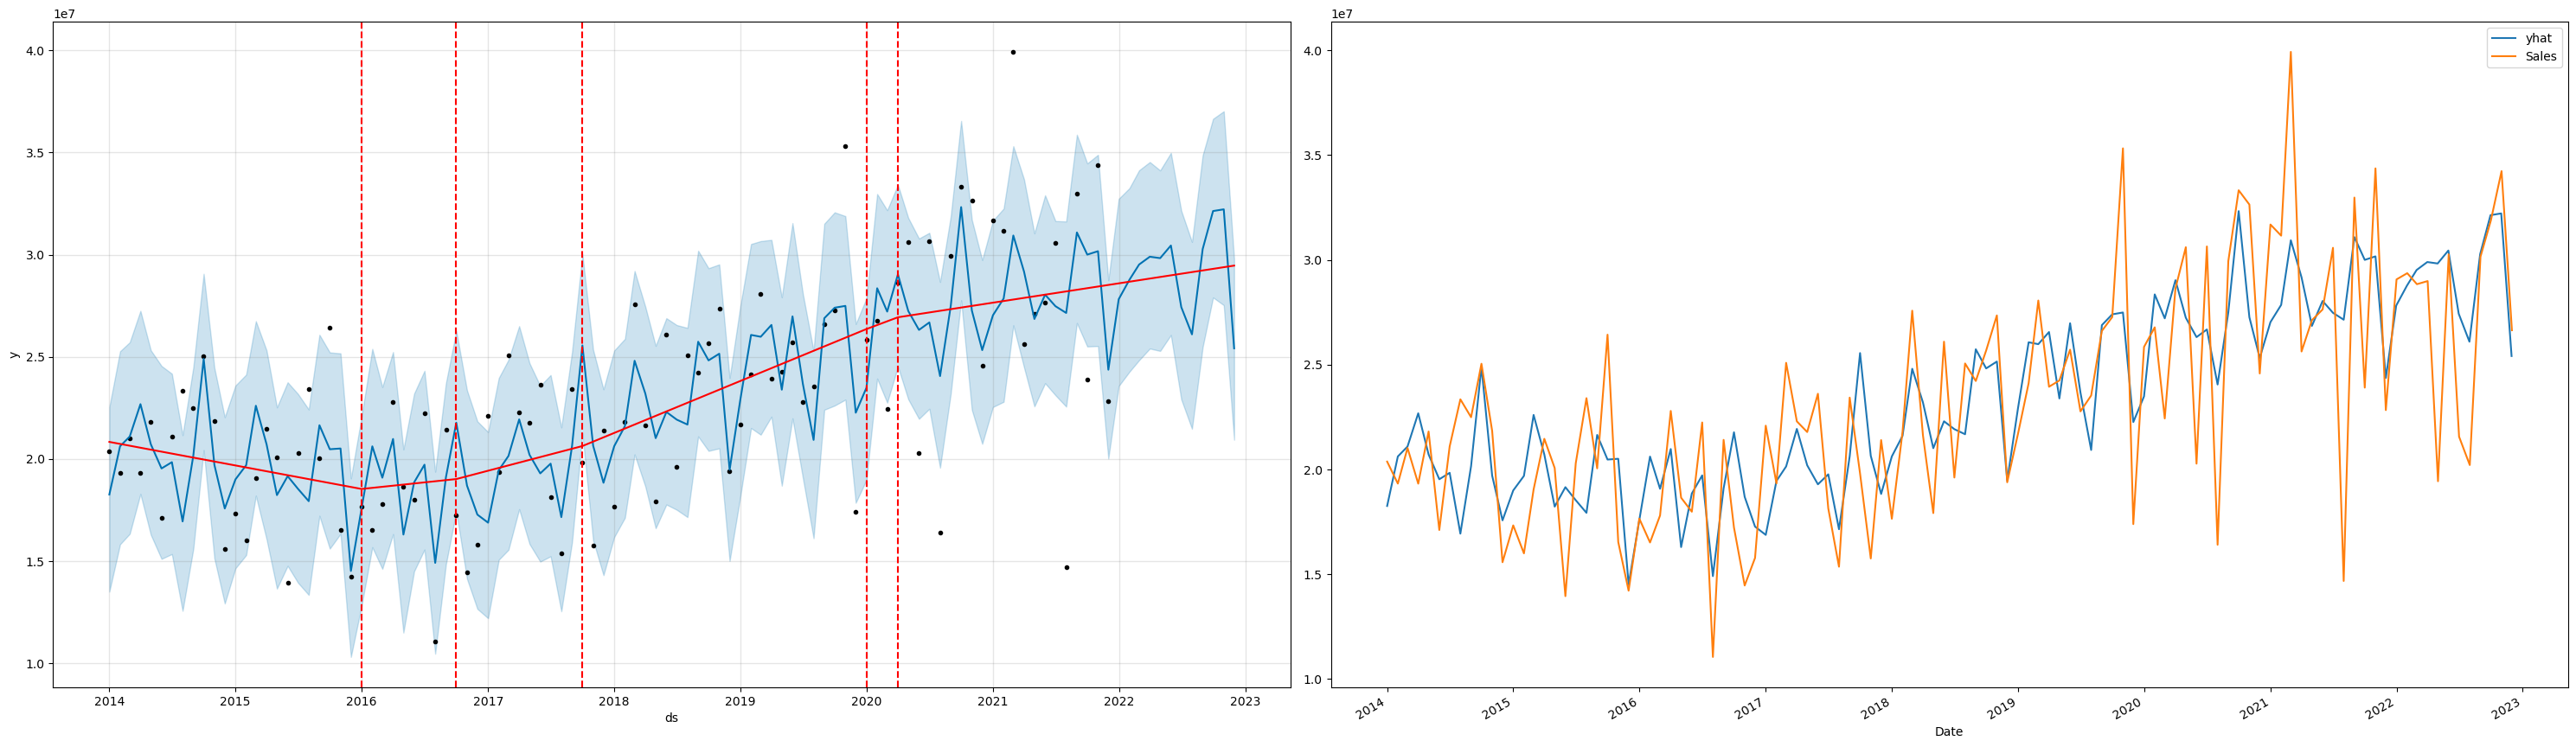

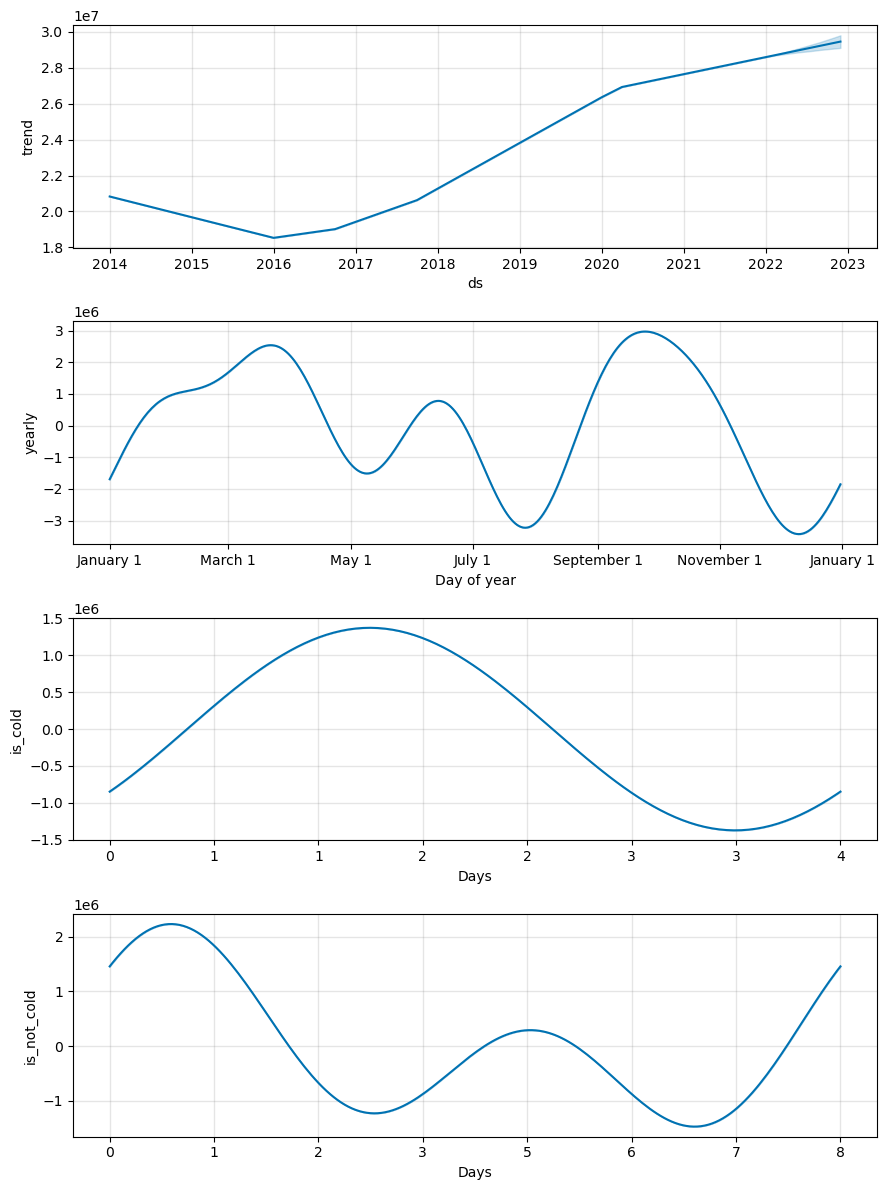

In [112]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import math

cutoff_train_test = 12
df_sales = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')

plot_prophet_with_parameters(df_sales, **{'changepoint_prior_scale': 7, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 3, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 2, 'quarterly_period': 1, 'yearly_seasonality': 5})
plot_prophet_with_parameters(df_sales, **{'changepoint_prior_scale': 2.5, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 1, 'quarterly_period': 1, 'yearly_seasonality': 5})
plot_prophet_with_parameters(df_sales, plot_components=True)


## Add external regressors

As we have seen in the other notebook, covid vaccination rates in Germany correlate with sales data. It is therefore possible that there is a link, however complex between general vaccine rates and sales. But general vaccine rates are hard to find, everything is just about covid. So I took data from google trends and verified that it does correlate with actual vaccine data (to do: formally verify the correlation). It is also worth adding CPI data even if we disable it at first

01:07:28 - cmdstanpy - INFO - Chain [1] start processing


Running with configuration: {'changepoint_prior_scale': 1, 'cpi_method': 'additive', 'cpi_period': 0, 'cpi_prior_scale': 0.5, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 1, 'iscold_period': 0, 'isnotcold_period': 0, 'quarterly_fourier_order': 5, 'quarterly_period': 4, 'vaccine_method': 'multiplicative', 'vaccine_period': 1, 'vaccine_prior_scale': 5, 'yearly_seasonality': 5}


01:07:29 - cmdstanpy - INFO - Chain [1] done processing
01:07:29 - cmdstanpy - INFO - Chain [1] start processing


error report:
Error using Prophet model: 3308801.238538714
Error using Naive prediction (constant value 28542093.665000003) model: 4609301.691495028
Prophet is 28.21% better than naive mean prediction
error report:
Error using Prophet model: 3308801.238538714
Error using Naive prediction (constant value 27555680.0) model: 4502516.883681473
Prophet is 26.51% better than naive mean prediction
Running with configuration: {'changepoint_prior_scale': 2, 'cpi_method': 'additive', 'cpi_period': 0, 'cpi_prior_scale': 0.5, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 1, 'iscold_period': 0, 'isnotcold_period': 0, 'quarterly_fourier_order': 5, 'quarterly_period': 4, 'vaccine_method': 'multiplicative', 'vaccine_period': 1, 'vaccine_prior_scale': 4, 'yearly_seasonality': 5}


01:07:30 - cmdstanpy - INFO - Chain [1] done processing
01:07:31 - cmdstanpy - INFO - Chain [1] start processing


error report:
Error using Prophet model: 3229359.4045917545
Error using Naive prediction (constant value 28542093.665000003) model: 4609301.691495028
Prophet is 29.94% better than naive mean prediction
error report:
Error using Prophet model: 3229359.4045917545
Error using Naive prediction (constant value 27555680.0) model: 4502516.883681473
Prophet is 28.28% better than naive mean prediction
Running with configuration: {'changepoint_prior_scale': 2, 'cpi_method': 'additive', 'cpi_period': 0, 'cpi_prior_scale': 0.5, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 1, 'quarterly_period': 1, 'vaccine_method': 'multiplicative', 'vaccine_period': 1, 'vaccine_prior_scale': 4, 'yearly_seasonality': 5}


01:07:32 - cmdstanpy - INFO - Chain [1] done processing


error report:
Error using Prophet model: 2757348.992857624
Error using Naive prediction (constant value 28542093.665000003) model: 4609301.691495028
Prophet is 40.18% better than naive mean prediction
error report:
Error using Prophet model: 2757348.992857624
Error using Naive prediction (constant value 27555680.0) model: 4502516.883681473
Prophet is 38.76% better than naive mean prediction


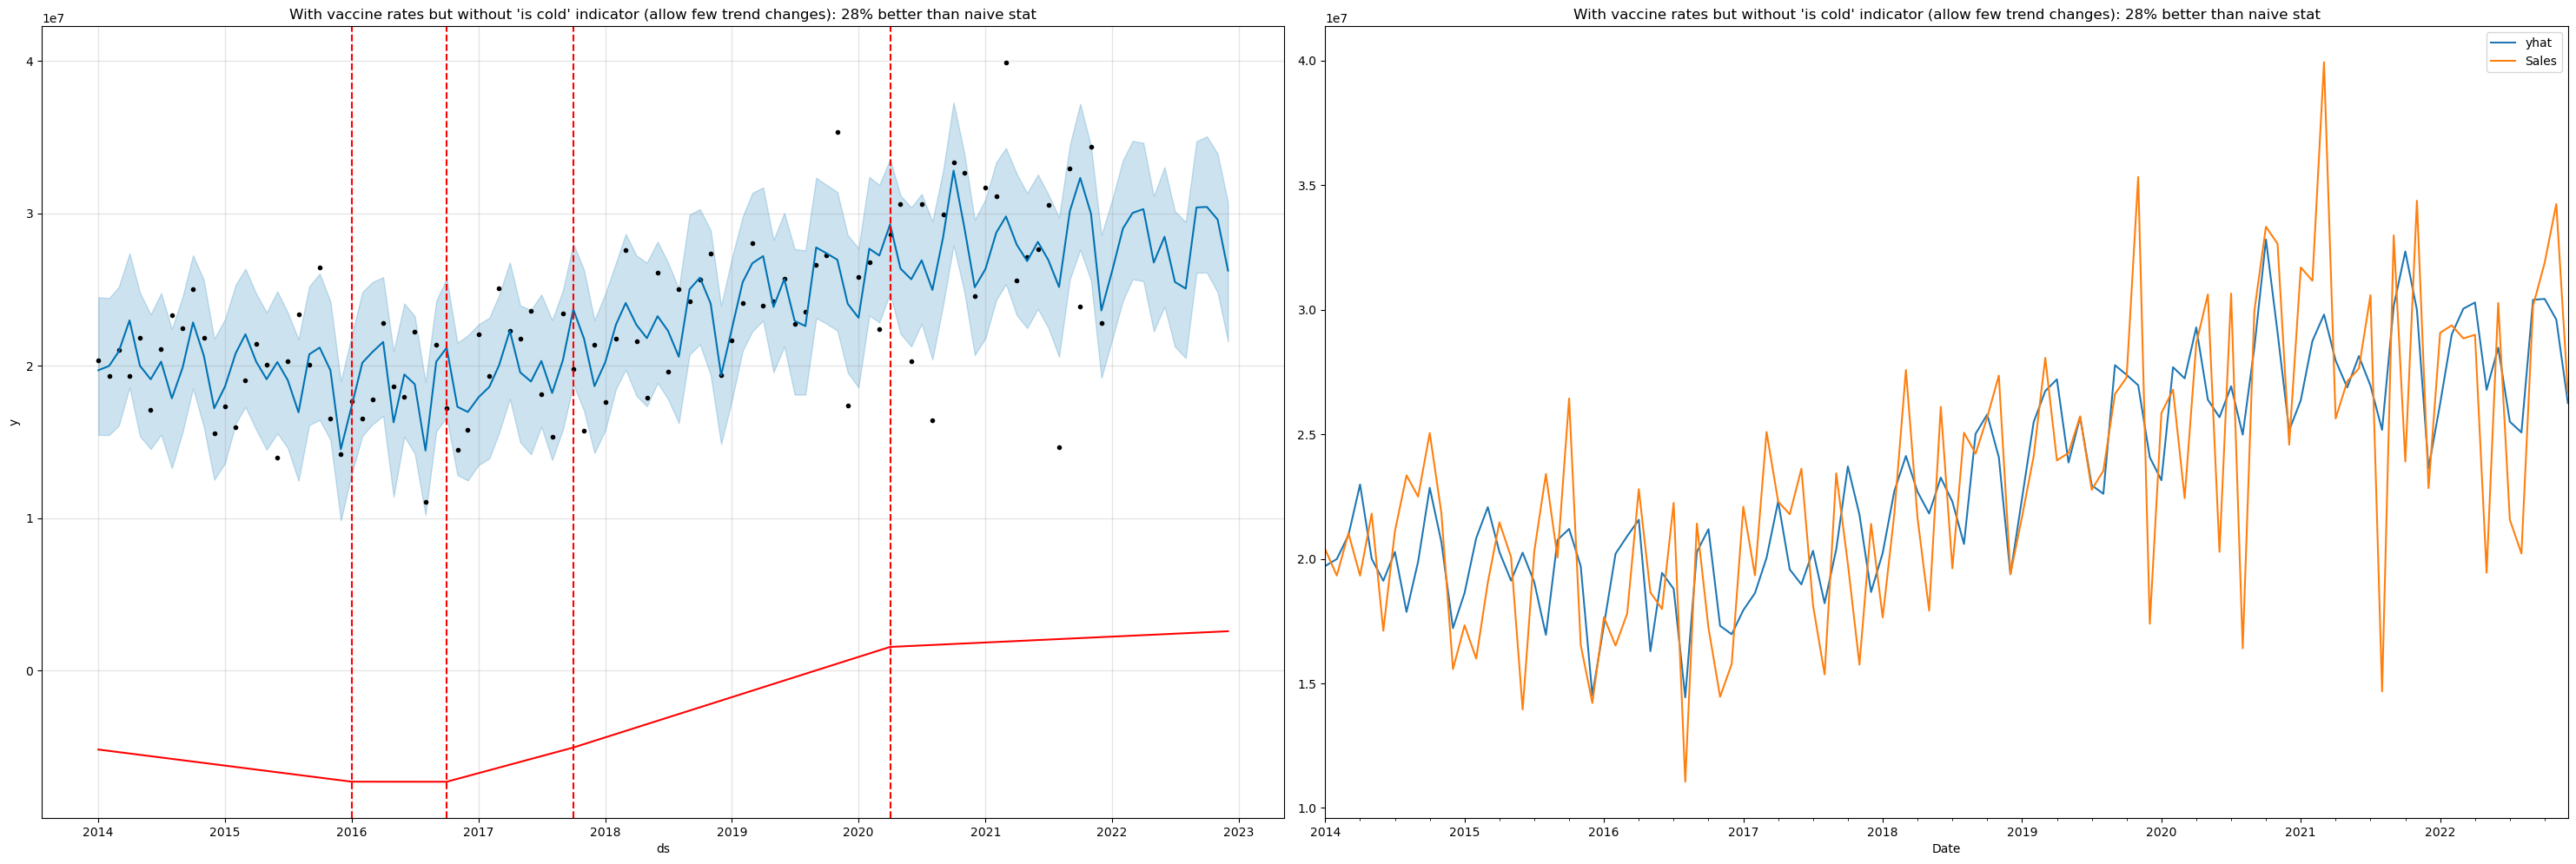

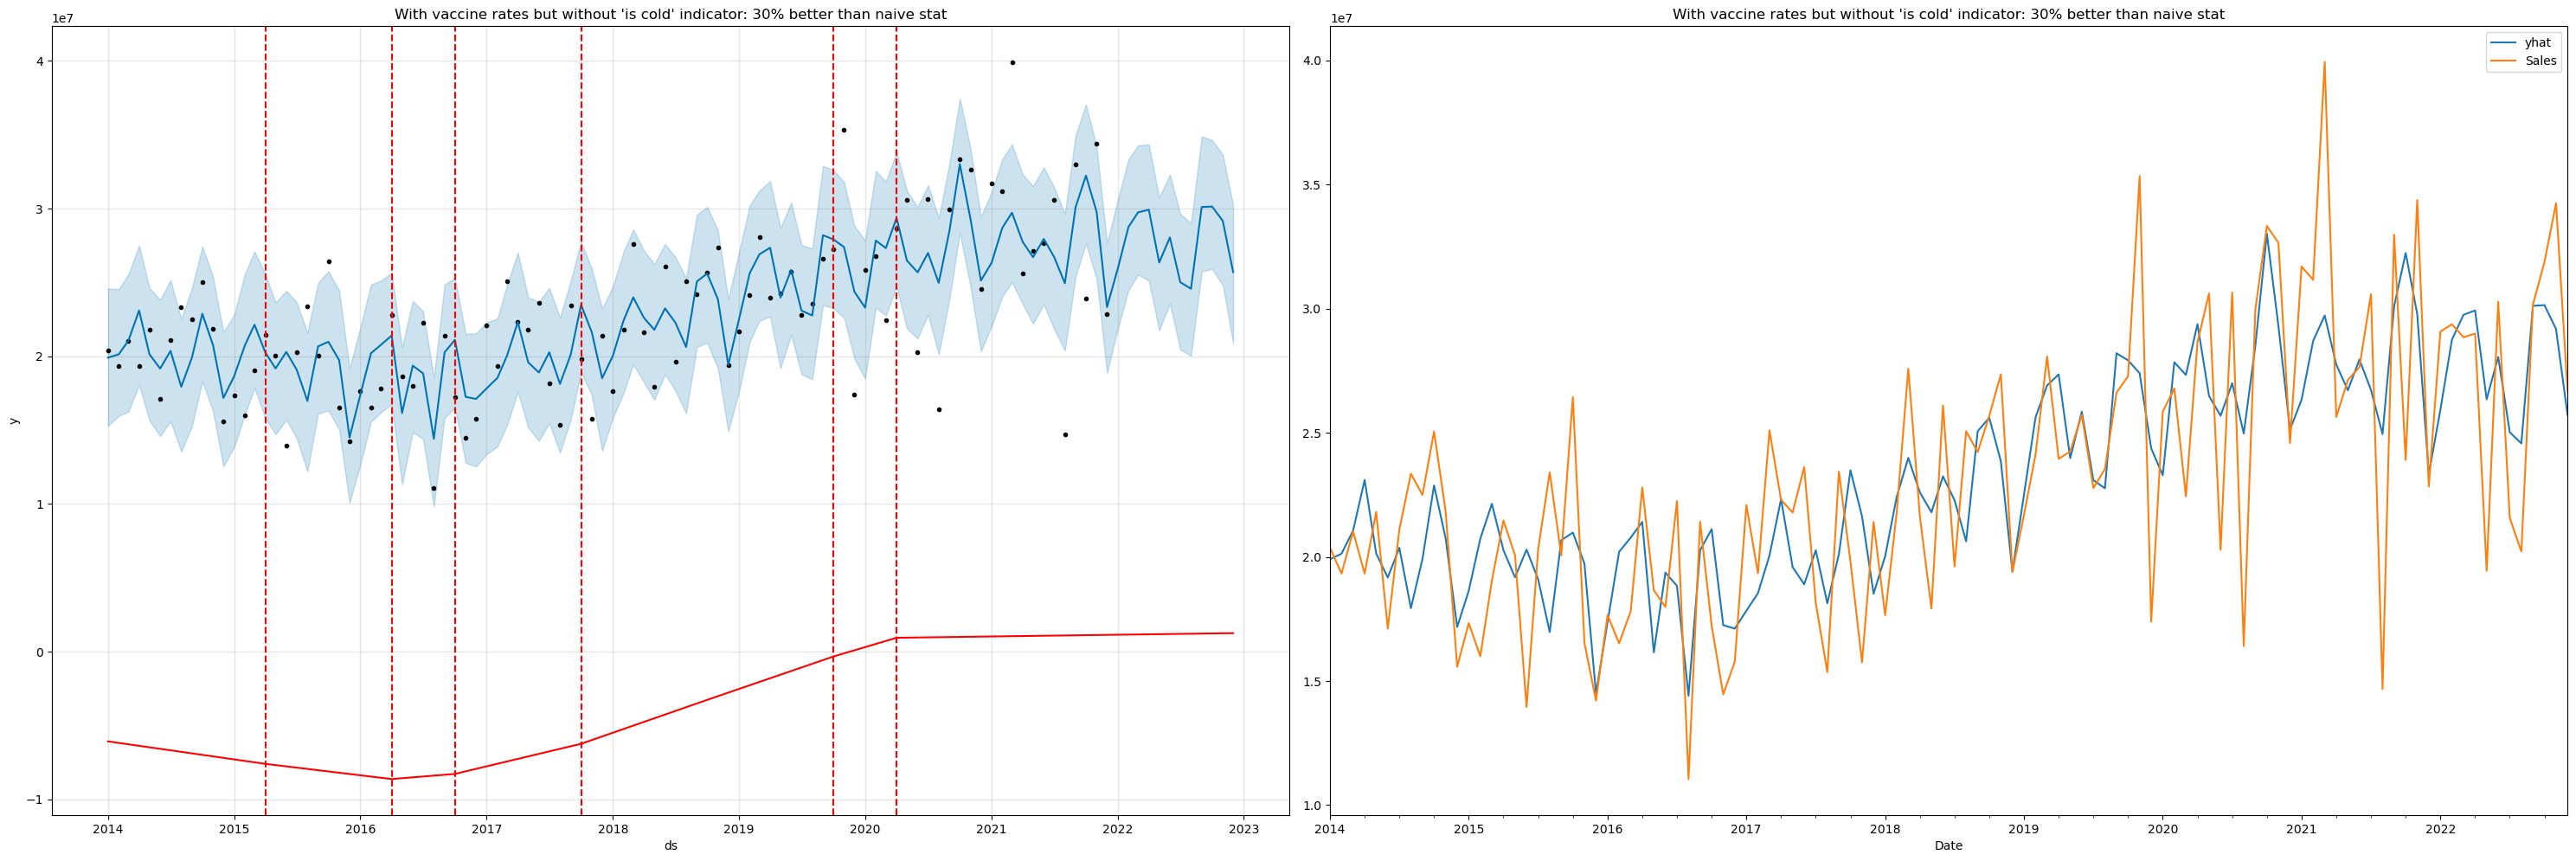

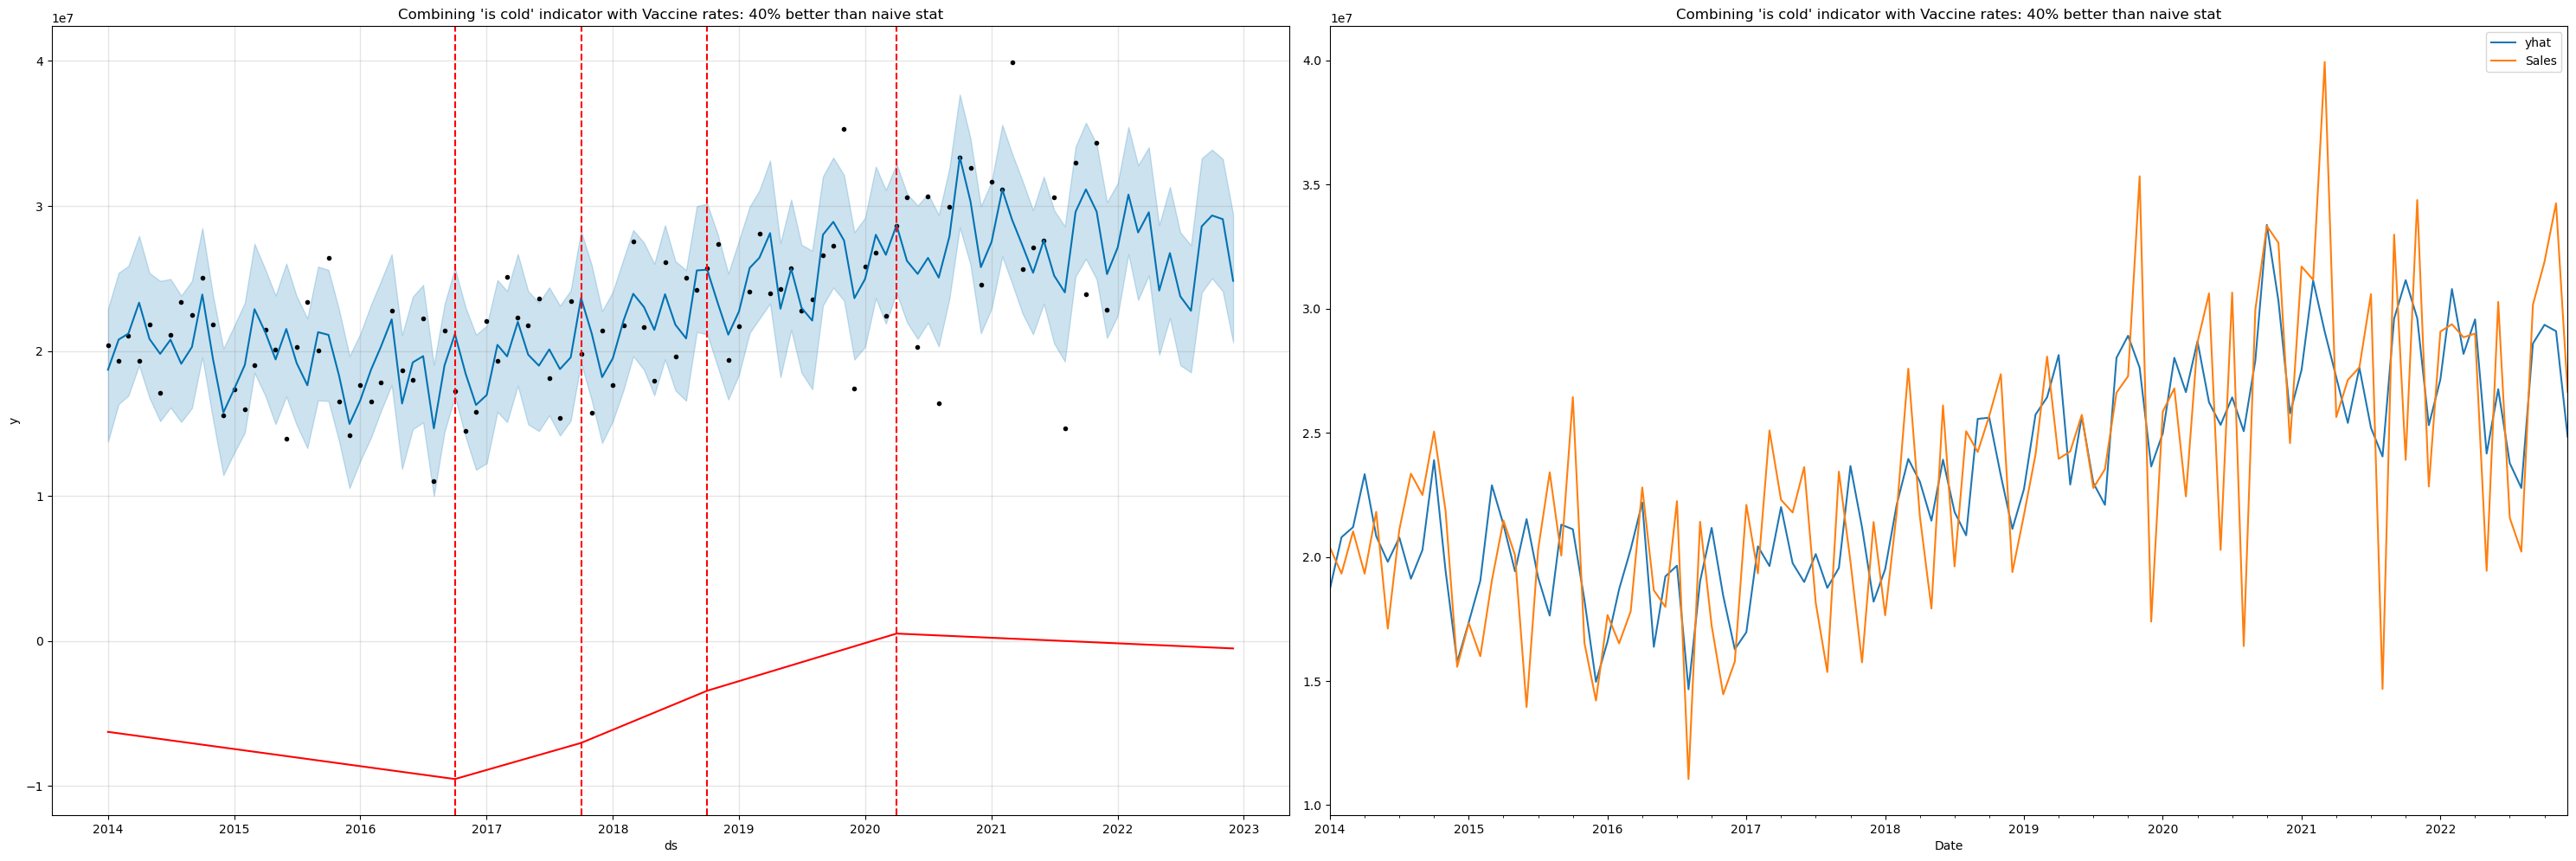

In [157]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import math

def plot_prophet_with_parameters_and_external_regressors(df_sales, df_external = None, plot_components=False, title=None, **kwargs):
        print("Running with configuration:", kwargs)
        fig, axes = plt.subplots(1, 2, figsize=(30, 10))
        if df_external is not None:
                df = pd.concat([df_sales, df_external], axis=1)
        else:
                df = df_sales
        df['ds'] = df.index
        df=df.rename(columns={ 'Sales':'y'})
        df = prepare_time_series(df)

        train_df = df[:-cutoff_train_test]
        test_df = df[-cutoff_train_test:]
        model = create_and_fit_model(train_df, **kwargs)

        future = model.make_future_dataframe(periods=12, freq = 'MS')
        future['Date'] = future['ds']
        future.set_index('Date', inplace=True)
        if df_external is not None:
                future = prepare_time_series(future, df[df_external.columns])
        else:
                future = prepare_time_series(future)

        forecast = model.predict(future)
        forecast['Date'] = forecast['ds']
        forecast.set_index('Date', inplace=True)
        fig = model.plot(forecast,ax=axes[0])
        if plot_components:
                model.plot_components(forecast)
        add_changepoints_to_plot(axes[0], model, forecast)

        viz_df = train_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')


        viz_df[['yhat']].plot(ax=axes[1])
        df_sales[['Sales']].plot(ax=axes[1])

        ref_err1 = train_df[-12:]['y'].mean()
        ref_err2 = 2.755568e+07
        err1 = print_mserr(test_df, forecast, ref_err1, 1e99)
        err2 = print_mserr(test_df, forecast, ref_err2, 1e99)
        axes[0].set_title(f"{title}: {get_percentage_err(test_df, forecast, ref_err1):.0%} better than naive stat")
        axes[1].set_title(f"{title}: {get_percentage_err(test_df, forecast, ref_err1):.0%} better than naive stat")


cutoff_train_test = 12
df_sales = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
df_vaccines = pd.read_csv("vaccines.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')

df_vaccines = df_vaccines.set_index('Date')

# restrict additional regressor to same time
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]

cpi_cz = [99.5, 99.6, 99.6, 99.6, 99.7, 99.7, 100.0, 99.9, 99.6, 99.8, 99.5, 99.5, 99.7, 99.5, 99.7, 99.8, 100.1, 100.4, 100.5, 100.4, 100.2, 100.0, 100.0, 99.6, 99.5, 100.0, 100.1, 100.2, 100.1, 100.7, 100.5, 100.6, 100.9, 100.8, 100.5, 100.8, 101.2, 101.5, 100.7, 102.3, 102.7, 102.7, 102.7, 102.9, 102.9, 103.4, 103.3, 103.2, 103.7, 103.8, 103.9, 103.1, 104.5, 104.5, 104.4, 104.7, 105.2, 105.6, 105.8, 105.9, 105.6, 106.0, 105.9, 106.0, 105.3, 107.1, 107.3, 107.5, 107.6, 108.3, 108.5, 108.9, 109.0, 108.4, 108.9, 109.2, 109.4, 108.3, 111.0, 111.3, 111.2, 111.0, 111.4, 112.1, 112.6, 112.6, 111.9, 112.1, 112.1, 111.9, 111.8, 113.4, 113.6, 113.8, 114.4, 114.6, 115.2, 116.4, 117.2, 117.4, 118.6, 118.8, 119.3, 116.1, 124.6, 126.2, 128.3, 130.6, 132.9, 135.0, 136.8, 137.4, 138.5, 136.5, 138.1, 138.1, 133.6, 146.4, 147.3]
data_cpi = {'Date': pd.date_range(start='2014-01-01', periods=len(cpi_cz), freq='MS'),
        'CPI': cpi_cz}

df_cpi = pd.DataFrame(data_cpi).set_index('Date')
df_cpi = df_cpi.loc[df_sales.index.min():df_sales.index.max(),:]
df_external = pd.concat([df_cpi, df_vaccines], axis=1)
df_external[['CPI', 'vaccine']]
kwargs = {'changepoint_prior_scale': 1, 'cpi_method': 'additive', 'cpi_period': 0, 'cpi_prior_scale': 0.5, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 1, 'iscold_period': 0, 'isnotcold_period': 0, 'quarterly_fourier_order': 5, 'quarterly_period': 4, 'vaccine_method': 'multiplicative', 'vaccine_period': 1, 'vaccine_prior_scale': 5, 'yearly_seasonality': 5}
plot_prophet_with_parameters_and_external_regressors(df_sales, df_external[['CPI', 'vaccine']],title="With vaccine rates but without 'is cold' indicator (allow few trend changes)", **kwargs)
kwargs = {'changepoint_prior_scale': 2, 'cpi_method': 'additive', 'cpi_period': 0, 'cpi_prior_scale': 0.5, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 1, 'iscold_period': 0, 'isnotcold_period': 0, 'quarterly_fourier_order': 5, 'quarterly_period': 4, 'vaccine_method': 'multiplicative', 'vaccine_period': 1, 'vaccine_prior_scale': 4, 'yearly_seasonality': 5} 
plot_prophet_with_parameters_and_external_regressors(df_sales, df_external[['CPI', 'vaccine']],title="With vaccine rates but without 'is cold' indicator", **kwargs)
# combine best trained model on is cold with vaccine prediction
plot_prophet_with_parameters_and_external_regressors(df_sales, df_external[['CPI', 'vaccine']], title="Combining 'is cold' indicator with Vaccine rates", **(kwargs | {'changepoint_prior_scale': 2, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 1, 'quarterly_period': 1, 'yearly_seasonality': 5}))
# previous best prediction
# df = df_sales.copy()
# df.index = pd.to_datetime(df_sales.index)
# plot_prophet_with_parameters(df, **{'changepoint_prior_scale': 2.5, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 1, 'quarterly_period': 1, 'yearly_seasonality': 5})


## Conclusion

* Adding vaccine data significantly increases (+15%) the MSE of the time series.
* CPI data exploration is in progress but so far does not seem to have an impact